### Focus: The "Uncensored" Truth.

### Imports and functtions

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def load_and_resample_data(filepath):
    """
    Loads H1 data from Parquet and resamples it to H4.
    """
    if not os.path.exists(filepath):
        print(f"❌ File not found: {filepath}")
        return None

    # Read Parquet
    df = pd.read_parquet(filepath)

    # Sanity check: ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Dynamic aggregation
    agg_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last'
    }
    
    if 'tick_volume' in df.columns:
        agg_dict['tick_volume'] = 'sum'
    
    if 'spread' in df.columns:
        agg_dict['spread'] = 'mean'

    # Resample to 4H
    df_4h = df.resample('4h').agg(agg_dict)
    
    # Drop NAs created by resampling (e.g., weekends)
    df_4h.dropna(inplace=True)
    
    return df_4h

def apply_triple_barrier_labels(df, t_barrier_periods, pt_mult, sl_mult):
    """
    df: The dataframe (already resampled to 4H)
    t_barrier_periods: The number of CANDLES to look ahead
    """
    df = df.copy()

    # 1. Calculate ATR (Volatility)--- the mighty Average True Range
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = abs(df['high'] - df['close'].shift(1))
    df['l-pc'] = abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)

    # We use this to make our targets dynamic 
    # (wider targets in volatile markets, tighter targets in calm markets).
    df['atr'] = df['tr'].rolling(window=14).mean()

    labels = []
    
    # Convert to numpy for speed--- the need for incredible speed
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values

    # this is s counter for all the events that go crazy (now only counting unresolvable ties)
    total_ambiguous = 0

    # Iterates through every single candle in the dataset.
    for i in range(len(df)):
        # Safety: Lookback (14 for ATR) and Lookahead (Horizon)
        if i < 14 or i + t_barrier_periods >= len(df):
            # If we hit these boundaries, we append NaN and skip to the next iteration.
            labels.append(np.nan)
            continue

        # grab the tools needed to label
        current_close = closes[i]
        current_atr = atrs[i]

        # ensure the atr is a valid number
        if np.isnan(current_atr):
            labels.append(np.nan)
            continue

        # Define Barriers -- based on the current
        upper_barrier = current_close + (pt_mult * current_atr)
        lower_barrier = current_close - (sl_mult * current_atr)
        
        # Look Forward -- based on the number of hours we oughta look forward the candles are automatically precalculated
        end_idx = i + t_barrier_periods

        # for each candle in the future how high or how low does the price go?
        future_highs = highs[i+1 : end_idx+1]
        future_lows = lows[i+1 : end_idx+1]

        outcome = 0 # Default: Timeout-- time ran out before hitting the next target
        
        # Check if barriers were hit
        # We check high/low against barriers. 
        # We create boolean masks to see EXACTLY WHERE the hits happened
        upper_mask = future_highs >= upper_barrier
        lower_mask = future_lows <= lower_barrier

        # Checks if at least one value in the future arrays touched the barriers
        hit_upper = np.any(upper_mask)
        hit_lower = np.any(lower_mask)

        if hit_upper and hit_lower:
            # Ambiguous: Price whipped both ways. 
            # We resolve this by checking WHO hit first (Time Context)
            
            # np.argmax returns the index of the FIRST 'True'
            upper_idx = np.argmax(upper_mask)
            lower_idx = np.argmax(lower_mask)
            
            if upper_idx < lower_idx:
                 outcome = 1 # Buy (Upper hit first)
            elif lower_idx < upper_idx:
                 outcome = -1 # Sell (Lower hit first)
            else:
                 # Rare case: Both hit in the EXACT SAME candle.
                 # We treat this as 0 (Timeout/No Trade) to be safe.
                 total_ambiguous += 1
                 outcome = 0
                 
        elif hit_upper:
            outcome = 1 # Buy
        elif hit_lower:
            outcome = -1 # Sell
        
        labels.append(outcome)
        
    print(f"  > Truly Ambiguous Events (Same-Candle Whipsaws): {total_ambiguous}")
        
    df['label'] = labels
    return df.dropna()

### 2: Execution Loop

In [66]:
# 1. Load Data
filepath = "../data/EURUSD_H1_Raw.parquet"
print(f"⏳ Loading and Resampling Data from {filepath}...")

# returns the resampled data
df_4h = load_and_resample_data(filepath) 

if df_4h is not None:
    print(f"✅ Data Resampled to H4. Rows: {len(df_4h)}")

    # 2. Define Parameters
    # We test different horizons to find the best class balance
    hour_horizons = [4, 8, 12, 16, 20, 24] 
    
    # Multipliers: 1.5x ATR is usually a balanced starting point for H4 -- 
    pt_multiplier = 1.0
    sl_multiplier = 1.0

    results = {}

    # 3. Process all scenarios
    for hours in hour_horizons:
        # Convert hours to H4 periods (e.g., 24h / 4h = 6 periods)
        # this determines how many indices in the future we have to look at 
        periods = int(hours / 4)
        
        print(f"\n⚙️ Processing Horizon: {hours} Hours ({periods} candles)...")
        
        labeled_df = apply_triple_barrier_labels(
            df_4h, 
            t_barrier_periods=periods, 
            pt_mult=pt_multiplier, 
            sl_mult=sl_multiplier
        )
        
        results[hours] = labeled_df

    print("\n✅ Processing Complete.")
else:
    print("❌ Failed to load data.")

⏳ Loading and Resampling Data from ../data/EURUSD_H1_Raw.parquet...
✅ Data Resampled to H4. Rows: 9349

⚙️ Processing Horizon: 4 Hours (1 candles)...
  > Truly Ambiguous Events (Same-Candle Whipsaws): 54

⚙️ Processing Horizon: 8 Hours (2 candles)...
  > Truly Ambiguous Events (Same-Candle Whipsaws): 106

⚙️ Processing Horizon: 12 Hours (3 candles)...
  > Truly Ambiguous Events (Same-Candle Whipsaws): 145

⚙️ Processing Horizon: 16 Hours (4 candles)...
  > Truly Ambiguous Events (Same-Candle Whipsaws): 171

⚙️ Processing Horizon: 20 Hours (5 candles)...
  > Truly Ambiguous Events (Same-Candle Whipsaws): 187

⚙️ Processing Horizon: 24 Hours (6 candles)...
  > Truly Ambiguous Events (Same-Candle Whipsaws): 192

✅ Processing Complete.


### 3: Save to Parquet

In [67]:
# 4. Save to Parquet
output_folder = '../data'
os.makedirs(output_folder, exist_ok=True)

print(f"💾 Saving files to: {output_folder} ...")

for hours, df in results.items():
    filename = f"triple_barrier_{hours}h.parquet"
    full_path = os.path.join(output_folder, filename)
    
    df.to_parquet(full_path, index=True)
    
    print(f"  -> Saved: {filename} ({len(df)} rows)")

print("\n✅ All files saved successfully.")

💾 Saving files to: ../data ...
  -> Saved: triple_barrier_4h.parquet (9334 rows)
  -> Saved: triple_barrier_8h.parquet (9333 rows)
  -> Saved: triple_barrier_12h.parquet (9332 rows)
  -> Saved: triple_barrier_16h.parquet (9331 rows)
  -> Saved: triple_barrier_20h.parquet (9330 rows)
  -> Saved: triple_barrier_24h.parquet (9329 rows)

✅ All files saved successfully.


### Visualization (NEW)

📈 Plotting last 20 candles for visual inspection...



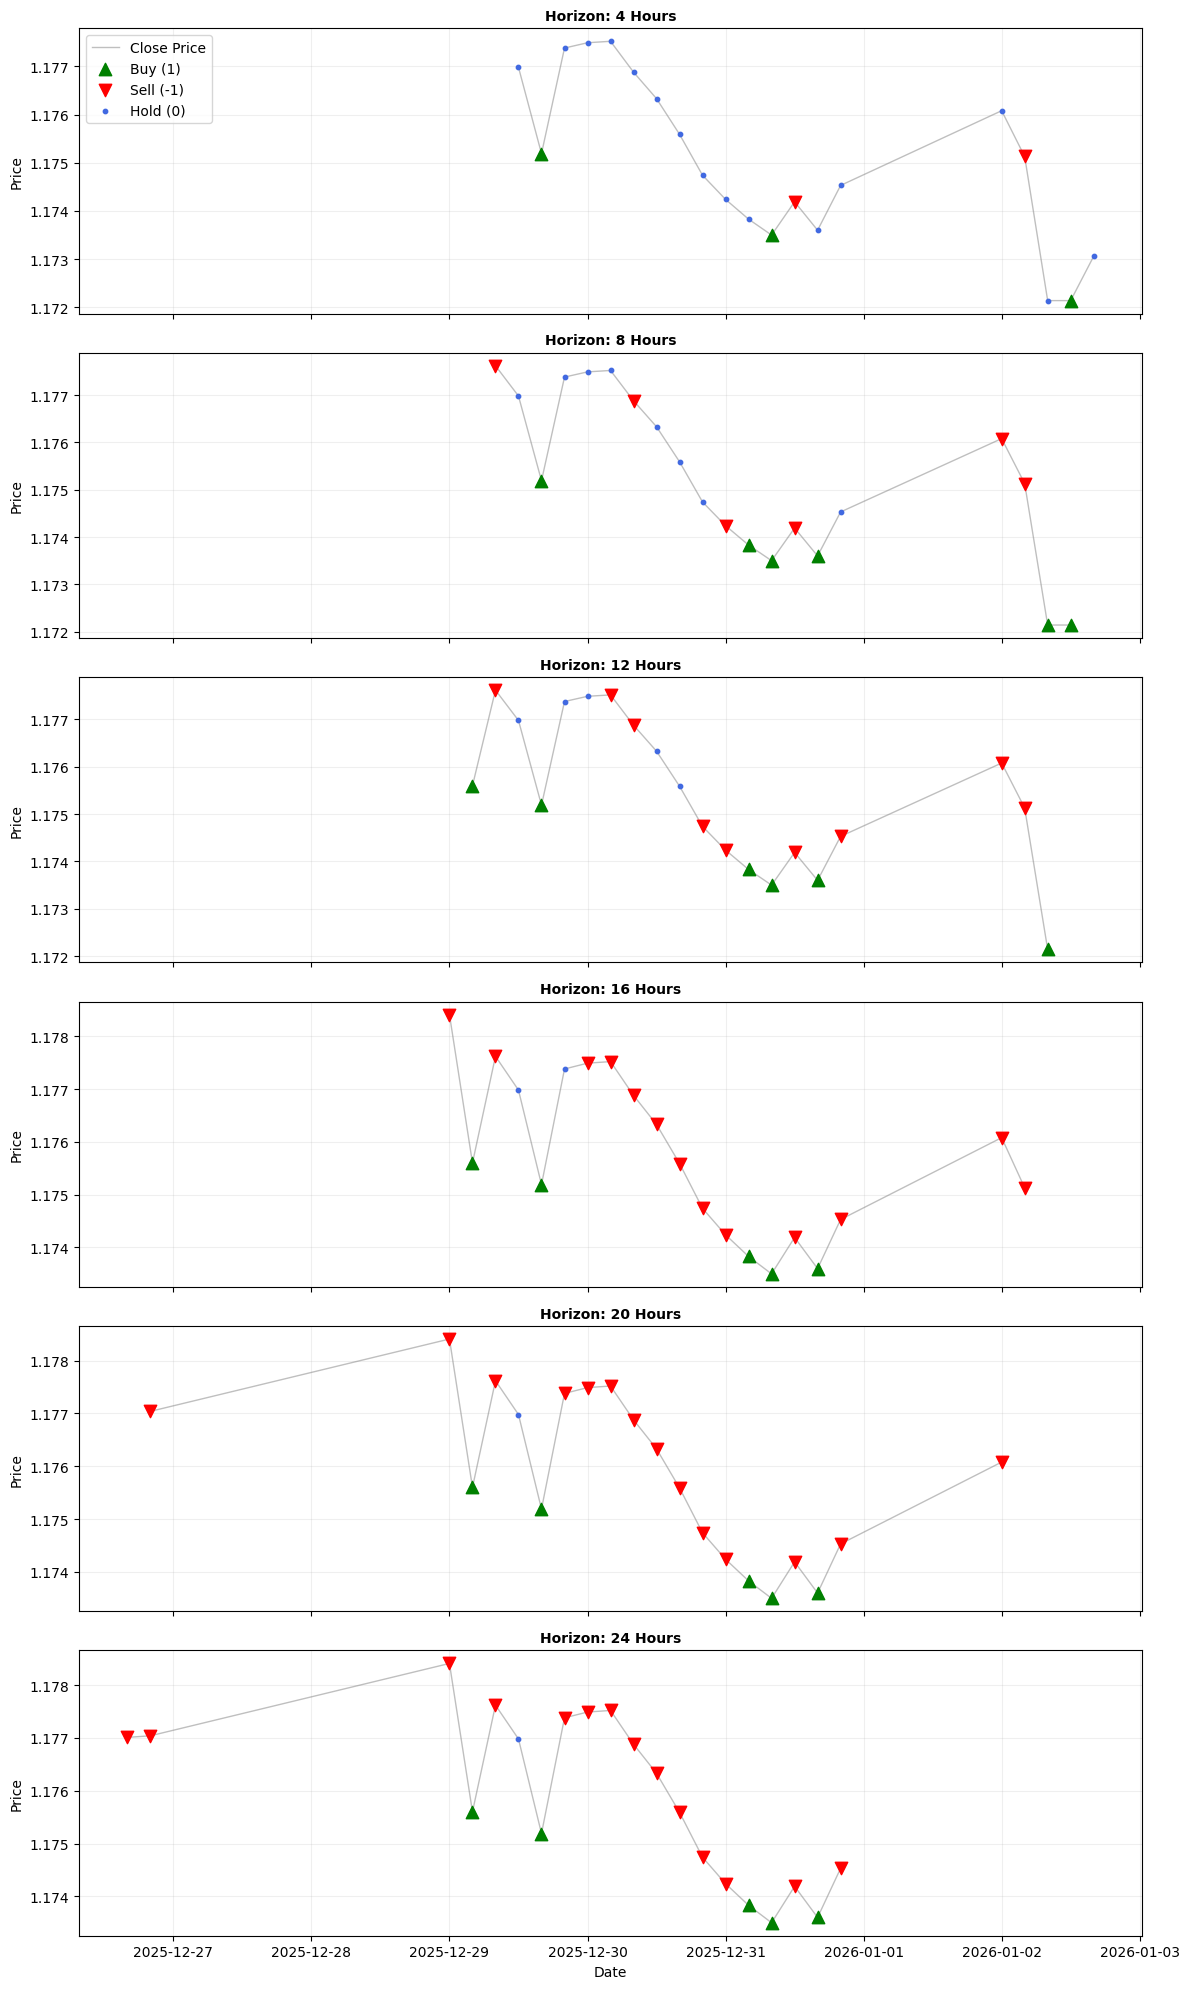

In [68]:
# 5. Visual Validation
import matplotlib.pyplot as plt
import pandas as pd
import os

data_folder = '../data'
hour_horizons = [4, 8, 12, 16, 20, 24] # Included 4h as per your snippet
plot_slice = 20 # Last 150 candles for visibility

fig, axes = plt.subplots(len(hour_horizons), 1, figsize=(12, 20), sharex=True)

print(f"📈 Plotting last {plot_slice} candles for visual inspection...\n")

for idx, hours in enumerate(hour_horizons):
    filename = f"triple_barrier_{hours}h.parquet"
    filepath = os.path.join(data_folder, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️ Warning: File not found for {hours}h horizon. Skipping.")
        continue
    
    df_full = pd.read_parquet(filepath)
    df_plot = df_full.iloc[-plot_slice:].copy()
    
    ax = axes[idx]
    
    # Plot Price
    ax.plot(df_plot.index, df_plot['close'], color='gray', alpha=0.5, linewidth=1, label='Close Price')
    
    # Filter Outcomes
    buys = df_plot[df_plot['label'] == 1]
    sells = df_plot[df_plot['label'] == -1]
    holds = df_plot[df_plot['label'] == 0]
    
    # Plot Markers
    # Green Up Arrow for BUY
    ax.scatter(buys.index, buys['close'], color='green', marker='^', s=80, label='Buy (1)', zorder=3)
    
    # Red Down Arrow for SELL (Short)
    ax.scatter(sells.index, sells['close'], color='red', marker='v', s=80, label='Sell (-1)', zorder=3)
    
    # Blue Dot for HOLD (Timeout)
    ax.scatter(holds.index, holds['close'], color='royalblue', marker='.', s=40, label='Hold (0)', zorder=2)
    
    ax.set_title(f"Horizon: {hours} Hours", fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("Price")
    
    if idx == 0:
        ax.legend(loc='upper left', frameon=True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

###  Class Balance Statistics

In [69]:
import pandas as pd
import os

# Setup
data_folder = '../data'
hour_horizons = [4, 8, 12, 16, 20, 24]

binary_stats = []

print("📊 Calculating Binary Signal vs. Noise Ratios...\n")

for hours in hour_horizons:
    filename = f"triple_barrier_{hours}h.parquet"
    filepath = os.path.join(data_folder, filename)
    
    if not os.path.exists(filepath):
        continue
        
    df = pd.read_parquet(filepath)
    total = len(df)
    
    # Count raw labels
    counts = df['label'].value_counts()
    n_buys = counts.get(1.0, 0)
    n_sells = counts.get(-1.0, 0)
    
    # --- BUY MODEL STATS ---
    # Target = Buy (1)
    # Noise  = Sell (-1) + Hold (0)
    buy_signal_pct = (n_buys / total) * 100
    buy_noise_pct = 100 - buy_signal_pct
    
    # --- SELL MODEL STATS ---
    # Target = Sell (-1)
    # Noise  = Buy (1) + Hold (0)
    sell_signal_pct = (n_sells / total) * 100
    sell_noise_pct = 100 - sell_signal_pct
    
    stats = {
        'Horizon': f"{hours} Hours",
        'Buy Signal %': round(buy_signal_pct, 2),
        'Buy Noise %': round(buy_noise_pct, 2),
        'Sell Signal %': round(sell_signal_pct, 2),
        'Sell Noise %': round(sell_noise_pct, 2),
        'Total Samples': total
    }
    binary_stats.append(stats)

# Create DataFrame
df_stats = pd.DataFrame(binary_stats)

# Display
import IPython.display as display
print("--- Binary Model Class Balance ---")
print("Note: 'Noise' includes both Holds (0) and the Opposite Trade.")
display.display(df_stats)

📊 Calculating Binary Signal vs. Noise Ratios...

--- Binary Model Class Balance ---
Note: 'Noise' includes both Holds (0) and the Opposite Trade.


,Horizon,Buy Signal %,Buy Noise %,Sell Signal %,Sell Noise %,Total Samples
0,4 Hours,12.33,87.67,12.68,87.32,9334
1,8 Hours,23.63,76.37,23.83,76.17,9333
2,12 Hours,31.93,68.07,31.68,68.32,9332
3,16 Hours,38.21,61.79,37.69,62.31,9331
4,20 Hours,42.11,57.89,42.08,57.92,9330
5,24 Hours,44.84,55.16,44.39,55.61,9329


In [70]:
# selected 12 since it is how long im willing to hold a trade

df_trial = pd.read_parquet('../data/triple_barrier_12h.parquet')

In [71]:
# Check the average size of the barrier in pips
avg_atr = df_trial['atr'].mean()
avg_barrier = avg_atr * 1
avg_pips = avg_barrier * 10000

print(f"Average H4 ATR: {avg_atr:.5f}")
print(f"Average Barrier Distance (1.5x): {avg_barrier:.5f}")
print(f"Average Target in Pips: {avg_pips:.1f} pips")

Average H4 ATR: 0.00300
Average Barrier Distance (1.5x): 0.00300
Average Target in Pips: 30.0 pips


In [ ]:
# if the atr is set to one, ona average we are looking for 30 pips, if set to 1.5 we are looking for 45 pips of movement